<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Gaining-the-data" data-toc-modified-id="Gaining-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gaining the data</a></span></li><li><span><a href="#Wrangling-the-raw-data" data-toc-modified-id="Wrangling-the-raw-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Wrangling the raw data</a></span></li><li><span><a href="#Refining-the-dataset" data-toc-modified-id="Refining-the-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Refining the dataset</a></span><ul class="toc-item"><li><span><a href="#Adding-weekdays" data-toc-modified-id="Adding-weekdays-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Adding weekdays</a></span></li><li><span><a href="#Adding-working-hours" data-toc-modified-id="Adding-working-hours-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Adding working hours</a></span></li></ul></li><li><span><a href="#Analyzing-the-data" data-toc-modified-id="Analyzing-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analyzing the data</a></span><ul class="toc-item"><li><span><a href="#Developers'-timezones" data-toc-modified-id="Developers'-timezones-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Developers' timezones</a></span></li><li><span><a href="#Weekdays-with-the-most-commits" data-toc-modified-id="Weekdays-with-the-most-commits-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Weekdays with the most commits</a></span></li><li><span><a href="#Working-behavior-on-weekends" data-toc-modified-id="Working-behavior-on-weekends-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Working behavior on weekends</a></span></li><li><span><a href="#Usual-working-hours" data-toc-modified-id="Usual-working-hours-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Usual working hours</a></span></li><li><span><a href="#Signs-of-overtime" data-toc-modified-id="Signs-of-overtime-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Signs of overtime</a></span></li></ul></li><li><span><a href="#Closing-remarks" data-toc-modified-id="Closing-remarks-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Closing remarks</a></span></li></ul></div>

# Introduction
In this blog post / notebook, we want to take a look at how much information you can extract from a simple [Git log](https://git-scm.com/docs/git-log) output. We want to know

* where the developers come from
* on which weekdays the developers don't work
* which developers are working on weekends
* what the normal working hours are and
* if the is any sight of overtime periods.

We use [Pandas](https://pandas.pydata.org/) as data analysis toolkit to accomplish these tasks for the big open source project [IntelliJ](https://github.com/JetBrains/intellij-community).

# Gaining the data

To get the necessary data, we clone the Git repository with

```
git clone https://github.com/JetBrains/intellij-community.git
```

and create a latin-1 encoded log file of the complete commit history with

```
git log --date=raw --encoding=LATIN-1 --pretty="%ad%x09%aN%x09%ae" > git_timestamp_author_email.log
```

on the command line.


This gives us a nice file with the following content:

```
1514469569 +0300	Kirill Kirichenko	kirill.kirichenko@jetbrains.com
1514469402 +0100	Anna Kozlova	anna.kozlova@jetbrains.com
1514469119 +0100	Vladimir Krivosheev	vladimir.krivosheev@jetbrains.com
1514468066 +0100	Vladimir Krivosheev	vladimir.krivosheev@jetbrains.com
1514462548 +0100	Vladimir Krivosheev	vladimir.krivosheev@jetbrains.com
...
```

It includes the UNIX timestamp (in seconds since epoch), a whitespace, the time zone (where the authors live in), a tab separator, the name of the author, a tab and the email address of the author.

Note:
* We use the `--date=raw` option that returns the UNIX timestamp in the UTC time zone and the author's time zone. We use the UNIX timestamp because Pandas can parse that data format very efficient. We need also the time zone because we want to know when each committer works at their local time.
* We've created and implicitly used a `.mailmap` file for this task to map multiple author names and email addresses to the same person. You can find this file in this [GitHub Gist](https://gist.github.com/feststelltaste/c341ca49c37e143b22bb9adeb84bf89e). To use it, the file has to be put into the root of the Git repository before the execution of the `git log` command.

# Wrangling the raw data

We import the data by using Pandas' `read_csv` function and the appropriate parameters.

In [1]:
import pandas as pd

raw = pd.read_csv(
    r'../../intellij-community/git_timestamp_author_email.log',
    sep="\t",
    encoding="latin-1",
    header=None,
    names=['unix_timestamp', 'author', 'email'])

raw.head()

,unix_timestamp,author,email
0,1514469569 +0300,Kirill Kirichenko,kirill.kirichenko@jetbrains.com
1,1514469402 +0100,Anna Kozlova,anna.kozlova@jetbrains.com
2,1514469119 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com
3,1514468066 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com
4,1514462548 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com


We need to split the information in `unix_timestamp` into the separate columns `timestamp` and `timezone`.

In [2]:
raw[['timestamp', 'timezone']] = raw['unix_timestamp'].str.split(" ", expand=True)
raw.head()

,unix_timestamp,author,email,timestamp,timezone
0,1514469569 +0300,Kirill Kirichenko,kirill.kirichenko@jetbrains.com,1514469569,+0300
1,1514469402 +0100,Anna Kozlova,anna.kozlova@jetbrains.com,1514469402,+0100
2,1514469119 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,1514469119,+0100
3,1514468066 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,1514468066,+0100
4,1514462548 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,1514462548,+0100


We also create a new numeric column for the timezone offset for later calculations.

In [3]:
raw['timezone_offset'] = pd.to_numeric(raw['timezone']) / 100.0
raw.head()

,unix_timestamp,author,email,timestamp,timezone,timezone_offset
0,1514469569 +0300,Kirill Kirichenko,kirill.kirichenko@jetbrains.com,1514469569,+0300,3.0
1,1514469402 +0100,Anna Kozlova,anna.kozlova@jetbrains.com,1514469402,+0100,1.0
2,1514469119 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,1514469119,+0100,1.0
3,1514468066 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,1514468066,+0100,1.0
4,1514462548 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,1514462548,+0100,1.0


To get a real time column, we convert the information in `timestamp` accordingly.

In [4]:
raw['timestamp'] = pd.to_datetime(raw['timestamp'], unit="s")
raw.head()

,unix_timestamp,author,email,timestamp,timezone,timezone_offset
0,1514469569 +0300,Kirill Kirichenko,kirill.kirichenko@jetbrains.com,2017-12-28 13:59:29,+0300,3.0
1,1514469402 +0100,Anna Kozlova,anna.kozlova@jetbrains.com,2017-12-28 13:56:42,+0100,1.0
2,1514469119 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,2017-12-28 13:51:59,+0100,1.0
3,1514468066 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,2017-12-28 13:34:26,+0100,1.0
4,1514462548 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,2017-12-28 12:02:28,+0100,1.0


We also calculate the local time of each commit by adding the `timezone_offset` data to the `timestamp` entries.

In [5]:
raw["timestamp_local"] = raw['timestamp'] + pd.to_timedelta(raw['timezone_offset'], unit='h')
raw.head()

,unix_timestamp,author,email,timestamp,timezone,timezone_offset,timestamp_local
0,1514469569 +0300,Kirill Kirichenko,kirill.kirichenko@jetbrains.com,2017-12-28 13:59:29,+0300,3.0,2017-12-28 16:59:29
1,1514469402 +0100,Anna Kozlova,anna.kozlova@jetbrains.com,2017-12-28 13:56:42,+0100,1.0,2017-12-28 14:56:42
2,1514469119 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,2017-12-28 13:51:59,+0100,1.0,2017-12-28 14:51:59
3,1514468066 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,2017-12-28 13:34:26,+0100,1.0,2017-12-28 14:34:26
4,1514462548 +0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,2017-12-28 12:02:28,+0100,1.0,2017-12-28 13:02:28


At last, we copy only the needed data from the `raw` dataset into the new DataFrame `git_authors`.

In [6]:
git_authors = raw[['timestamp_local', 'timezone', 'author', 'email']].copy()
git_authors.head()

,timestamp_local,timezone,author,email
0,2017-12-28 16:59:29,+0300,Kirill Kirichenko,kirill.kirichenko@jetbrains.com
1,2017-12-28 14:56:42,+0100,Anna Kozlova,anna.kozlova@jetbrains.com
2,2017-12-28 14:51:59,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com
3,2017-12-28 14:34:26,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com
4,2017-12-28 13:02:28,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com


# Refining the dataset
In this section, we add some additional information to the `DataFrame` to accomplish our tasks.

## Adding weekdays
First, we add the information about the weekdays based on the `dayofweek` information of the `timestamp_local` column. We round down possible non-integer values and extract the weekday name from the `calender.day_name` list. Because we want to preserve the order of the weekdays, we convert the `day` entries to a `Categorial` data type, too.

In [7]:
import calendar

git_authors['day'] = git_authors["timestamp_local"].apply(lambda x : calendar.day_name[int(x.dayofweek)])
git_authors['day'] = pd.Categorical(git_authors['day'], categories=calendar.day_name, ordered=True)
git_authors.head()

,timestamp_local,timezone,author,email,day
0,2017-12-28 16:59:29,+0300,Kirill Kirichenko,kirill.kirichenko@jetbrains.com,Thursday
1,2017-12-28 14:56:42,+0100,Anna Kozlova,anna.kozlova@jetbrains.com,Thursday
2,2017-12-28 14:51:59,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,Thursday
3,2017-12-28 14:34:26,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,Thursday
4,2017-12-28 13:02:28,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,Thursday


## Adding working hours
For the working hour analysis, we extract the hour information from the `timestamp_local` columns.

In [8]:
git_authors['hour'] = git_authors['timestamp_local'].dt.hour
git_authors.head()

,timestamp_local,timezone,author,email,day,hour
0,2017-12-28 16:59:29,+0300,Kirill Kirichenko,kirill.kirichenko@jetbrains.com,Thursday,16
1,2017-12-28 14:56:42,+0100,Anna Kozlova,anna.kozlova@jetbrains.com,Thursday,14
2,2017-12-28 14:51:59,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,Thursday,14
3,2017-12-28 14:34:26,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,Thursday,14
4,2017-12-28 13:02:28,+0100,Vladimir Krivosheev,vladimir.krivosheev@jetbrains.com,Thursday,13


# Analyzing the data
With the prepared `git_authors` DataFrame, we are now able to deliver insights into the past years of development.

## Developers' timezones
First, we want to know where the developers roughly live. For this, we plot the values of the `timezone` columns as a pie chart.

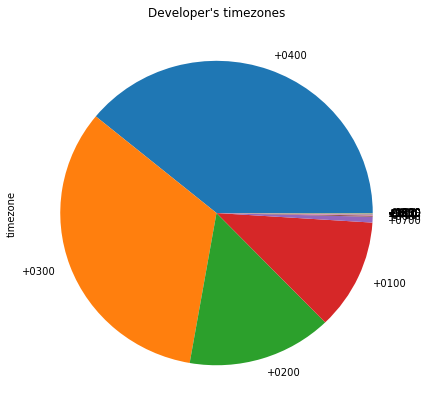

In [9]:
%matplotlib inline
git_authors['timezone'].value_counts().plot(kind='pie', figsize=(7,7), title="Developer's timezones")

**Result**

The majority of the developers' lives in the time zones +0300 and +0400. Looking at a time zone map ([source](https://commons.wikimedia.org/wiki/File:Standard_World_Time_Zones.png)) and on the [website](https://www.jetbrains.com/company/contacts/) of the company that mainly maintains the project, we can defer that most of the developers are probably working from Russia.

![](resources/developers_habits_timezone.png)

## Weekdays with the most commits

Next, we want to know on which days the developers are working during the week. We count by the weekdays but avoid sorting the results to keep the order along our categories.

In [10]:
commits_per_weekday = git_authors['day'].value_counts(sort=False)
commits_per_weekday

Monday       38605
Tuesday      40611
Wednesday    40988
Thursday     40487
Friday       37459
Saturday      6896
Sunday        5355
Name: day, dtype: int64

We plot the result as a standard bar chart.

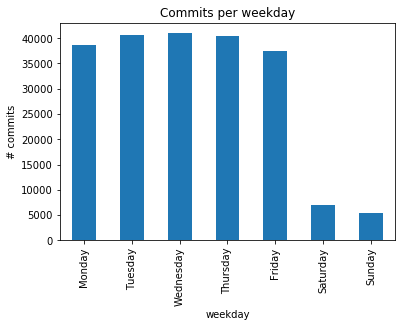

In [11]:
ax = commits_per_weekday.plot(kind='bar', title="Commits per weekday")
ax.set_xlabel('weekday')
ax.set_ylabel('# commits')

**Result:** 

Most of the commits occur during normal working days. There are just a few commits on weekends.

## Working behavior on weekends
We take a look at the type of weekend workers. We want to see, if the commits come from the main developing company JetBrains or from other voluntary contributors that work on the open source project on weekends.

As an approximation, we use the domain name that is included in the author's email addresses to decide if an author is an employee of JetBrains or not. We use a separate DataFrame `weekend_workers` for this task.

In [12]:
weekend_workers = git_authors[['day', 'email']].copy()
weekend_workers['employee'] = weekend_workers['email'].str.lower().str.endswith("@jetbrains.com")
weekend_workers.head()

,day,email,employee
0,Thursday,kirill.kirichenko@jetbrains.com,True
1,Thursday,anna.kozlova@jetbrains.com,True
2,Thursday,vladimir.krivosheev@jetbrains.com,True
3,Thursday,vladimir.krivosheev@jetbrains.com,True
4,Thursday,vladimir.krivosheev@jetbrains.com,True


We group and count the weekdays and employee information and store the result in the new DataFrame `commits_per_weekday_employee`. 

In [13]:
commits_per_weekday_employee = weekend_workers.groupby(['day', 'employee']).count().unstack()
commits_per_weekday_employee

email       
employee  False  True 
day                   
Monday     6428  32177
Tuesday    6411  34200
Wednesday  6515  34473
Thursday   6658  33829
Friday     5720  31739
Saturday   1353   5543
Sunday      933   4422

To be able to spot differences more easily, we calculate the ratio between the employed developers and all developers.

In [14]:
commits_per_weekday_employee['employed_ratio'] = \
  commits_per_weekday_employee['email'][True] / \
    commits_per_weekday_employee['email'].sum(axis=1)
commits_per_weekday_employee

email        employed_ratio
employee  False   True               
day                                  
Monday     6428  32177       0.833493
Tuesday    6411  34200       0.842136
Wednesday  6515  34473       0.841051
Thursday   6658  33829       0.835552
Friday     5720  31739       0.847300
Saturday   1353   5543       0.803799
Sunday      933   4422       0.825770

We plot this new information in a second bar chart to see possible differences in the committing behavior between IntelliJ employees and other contributors.

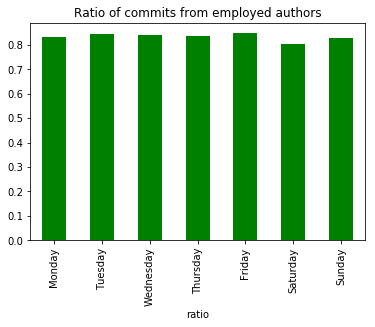

In [15]:
ax = commits_per_weekday_employee['employed_ratio'].plot(
    kind='bar', color='g', title="Ratio of commits from employed authors")
ax.set_xlabel("weekdays")
ax.set_xlabel("ratio")

**Result**

There is only a slight, non-significant difference between the ratio of employed and non-employed contributors on weekends.

## Usual working hours
To find out about the working habits of the contributors, we group the commits by `hour` and count the entries (in this case we choose `author`) to see if there are any irregularities.

In [16]:
working_hours = git_authors.groupby(['hour'])['author'].count()
working_hours.head()

hour
0    2083
1    1397
2     825
3     485
4     311
Name: author, dtype: int64

Again, we plot the results with a standard bar chart.

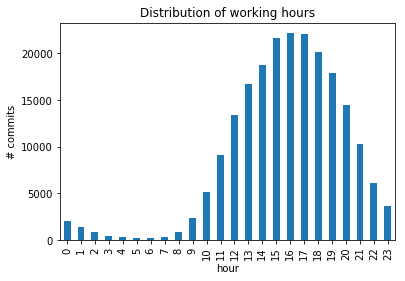

In [17]:
ax = working_hours.plot(kind='bar')
ax.set_title("Distribution of working hours")
ax.yaxis.set_label_text("# commits")
ax.xaxis.set_label_text("hour")

**Result**

The distribution of the working hours is a nice Gaussian distribution. It seems that this open source project is mainly developed by developers in their full-time jobs.

## Signs of overtime 

At last, we have a look at possible overtime periods. For this, we first group all commits on a weekly basis per authors. As grouping function, we choose `max()` to get the hour where each author committed at latest per week.

In [18]:
latest_hour_per_week  = git_authors.groupby(
    [
        pd.Grouper(key='timestamp_local', freq='1w'), 
        'author']
)[['hour']].max()

latest_hour_per_week.head()

hour
timestamp_local author                 
2004-11-07      Olesya Smirnova      20
2004-11-14      Alexey Kudravtsev    16
                Olesya Smirnova      22
2004-11-21      Anna Kozlova         21
                Olesya Smirnova      19

Next, we want to know if there were any stressful time periods that forced the developers to work overtime over a longer period of time. We calculate the mean of all late stays of all authors for each week.

In [19]:
mean_latest_hours_per_week = latest_hour_per_week.reset_index().groupby('timestamp_local').mean()
mean_latest_hours_per_week.head()

,hour
timestamp_local,
2004-11-07,20.000000
2004-11-14,19.000000
2004-11-21,13.666667
2004-12-05,16.666667
2004-12-12,15.333333


We also create a trend line that shows how the contributors are working over the span of the past years. We use the `polyfit` function from `numpy` for this which needs a numeric index to calculate the polynomial coefficients later on.

In [20]:
numeric_index = range(0, len(mean_latest_hours_per_week.index.week))
numeric_index

range(0, 684)

We then calculate the coeffiecients with a three-dimensional polynomial based on the hours of the `mean_latest_hours_per_week` DataFrame.

In [21]:
import numpy as np
coefficients = np.polyfit(numeric_index, mean_latest_hours_per_week.hour, 3)
coefficients

array([ -2.35626413e-08,   2.54703899e-05,  -9.85330587e-03,
         2.02637516e+01])

For visualization, we decrease the number of degrees and calculate the y-coordinates for all weeks that are encoded in `numeric_index`.

In [22]:
polynomial = np.poly1d(coefficients)
ys = polynomial(numeric_index)
ys[:5]

array([ 20.2637516 ,  20.25392374,  20.24414669,  20.23442028,  20.2247444 ])

At last, we plot the results of the `mean_latest_hours_per_week` DataFrame as well as the trend line in one line plot.

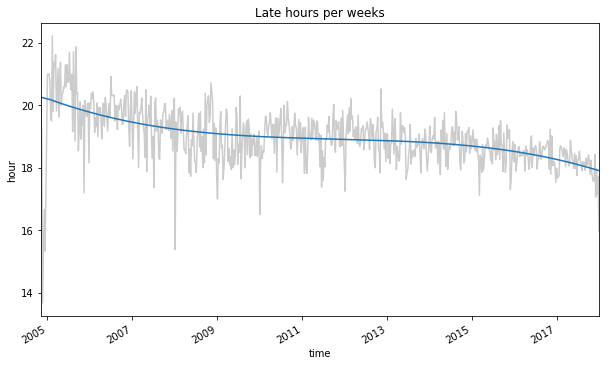

In [23]:
ax = mean_latest_hours_per_week['hour'].plot(
    figsize=(10, 6), color='k', alpha=0.2, title="Late hours per weeks")
ax.set_xlabel("time")
ax.set_ylabel("hour")
ax.plot(mean_latest_hours_per_week.index, ys)

**Result**

We can see that the late hours are decreasing over time (almost two hours during the last 12 years). There is no sign of regular death marches. In general, this could be a good sign, leading to a work-life balance.

# Closing remarks

We've seen that various metrics and results can be easily created from a simple Git log output file. With Pandas, it's possible to get to know the habits of the developers of software projects.